# nbjob

This file contains the core code for `nbjob`.

In [3]:
try:
    # When this file is run as part of the nbjob package, relative imports are allowed
    from .structs import Struct, impl, init
    from . import ipyparallel_display
except SystemError:
    # This file is a Jupyter notebook precisely to allow opening it in Jupyter
    # during development. Don't use relative imports here
    import notebook_import_hooks
    from nbjob_dev.structs import Struct, impl, init
    import nbjob_dev.ipyparallel_display

### Hack to fix behavior of inspect module
See: https://bugs.python.org/issue12920

In [4]:
import inspect, sys

def new_getfile(object, _old_getfile=inspect.getfile):
    if not inspect.isclass(object):
        return _old_getfile(object)
    
    # Lookup by parent module
    if hasattr(object, '__module__'):
        object_ = sys.modules.get(object.__module__)
        if hasattr(object_, '__file__'):
            return object_.__file__
    
    # If parent module is __main__, lookup by methods
    for name, member in inspect.getmembers(object):
        if inspect.isfunction(member) and object.__qualname__ + '.' + member.__name__ == member.__qualname__:
            return inspect.getfile(member)
    else:
        raise TypeError('Source for {!r} not found'.format(object))
inspect.getfile = new_getfile

## MongoDB job database

In [6]:
from pymongo import MongoClient
from bson.objectid import ObjectId

In [7]:
class DBWrapper(metaclass=Struct):
    def __init__(self, *args, **kwargs):
        self.client = MongoClient()
        self.db = self.client.db
        self.entries = self.db.entries_test
    
    def get_entry(self, _id):
        from bson.objectid import ObjectId
        return Entry(self, ObjectId(_id))
    
    def root_entry(self):
        res = self.entries.insert_one({
                'type' : Entry.TYPE_CHECKPOINT,
                'names' : [],
                'prev' : None
            })
        
        return Entry(self, res.inserted_id)

In [8]:
class Entry(object):
    TYPE_SRC = 'src'
    TYPE_CHECKPOINT = 'checkpoint'
    TYPE_BINARY = 'binary'
    
    valid_types = [TYPE_SRC, TYPE_CHECKPOINT, TYPE_BINARY]
    def __init__(self, wrapper, _id):
        self.wrapper = wrapper
        self._id = _id
        self._data = None
        
    @property
    def prev(self):
        prev_id = self.wrapper.entries.find_one({'_id' : self._id}, {'prev' : True})['prev']
        if prev_id is None:
            return None
        else:
            return Entry(self.wrapper, prev_id)
    
    @property
    def type(self):
        res = self.wrapper.entries.find_one({'_id' : self._id}, {'type' : True})['type']
        assert (res in Entry.valid_types)
        return res
    
    @property
    def names(self):
        res = self.wrapper.entries.find_one({'_id' : self._id}, {'names' : True})['names']
        res = set(res)
        return res
    
    # TYPE_SRC
    
    @property
    def src(self):
        if self.type != Entry.TYPE_SRC:
            return ""
        res = self.wrapper.entries.find_one({'_id' : self._id}, {'src' : True})['src']
        return res
    
    # All types
    def new(self, *args, **kwargs):
        arg1, *_ = args
        if isinstance(arg1, list):
            return self._new_history(*args, **kwargs)
        else:
            raise NotImplementedError()

    def _new_history(self, history):
        current = self
        for names, src in history:
            current = current._new_entry(type=Entry.TYPE_SRC, names=names, src=src)
        return current
    
    def _new_entry(self, type, names=set(), src=""):
        d = {}
        if type == Entry.TYPE_SRC:
            if not (isinstance(names, set) and isinstance(src, str)):
                raise ValueError()
            d['type'] = type
            d['names'] = list(names)
            d['src'] = src
            d['prev'] = self._id
        elif type == Entry.TYPE_CHECKPOINT:
            d['type'] = type
            if names != set():
                raise ValueError()
            d['names'] = []
            d['prev'] = self._id
        else:
            raise ValueError("Invalid type")
            
        new_id = self.wrapper.entries.insert_one(d).inserted_id
        return Entry(self.wrapper, new_id)
    
    def checkpoint(self):
        return self._new_entry(type=Entry.TYPE_CHECKPOINT)
    
    def __repr__(self):
        if self._id is None:
            return "Entry()"
        else:
            return repr(self._id).replace('ObjectId', 'Entry')
        
    @property
    def history(self):
        res = []
        current = self
        num_checkpoints = 0
        checkpoint_names = set()
        while current is not None:
            if current.type == 'src':
                if num_checkpoints or checkpoint_names:
                    res.append((checkpoint_names, '#Omitted {} checkpoints'.format(num_checkpoints)))
                    num_checkpoints = 0
                    checkpoint_names = set()
                res.append((current.names, current.src))
            elif current.type == 'checkpoint':
                num_checkpoints += 1
            elif current.type == 'binary':
                checkpoint_names |= current.names
            current = current.prev
        res = res[::-1]
        return res

In [56]:
class DummyJobtracker():
    def checkpoint(self):
        pass
    
    def register_checkpointer(self, varname, gettername=None, settername=None):
        # Sanity check
        import __main__, pickle
        if gettername is not None:
            getter = eval(gettername, __main__.__dict__)
        else:
            getter = lambda: eval(varname, __main__.__dict__)

        if settername is not None:
            setter = eval(settername, __main__.__dict__)
        else:
            def setter(val):
                __main__.__dict__['_setter_proxy'] = val
                exec("{} = _setter_proxy".format(varname), __main__.__dict__)
                del __main__.__dict__['_setter_proxy']

        vals = getter()
        setter(pickle.loads(pickle.dumps(vals)))
        vals2 = getter()

In [10]:
def remote_create_job():
    """
    First entry point for code executed on the remote end
    
    This creates a job tracker and returns its job id to the main system
    """
    import bson, pickle
    # Job tracker class
    class JobTracker():
        def __init__(self, old_tracker=None):
            from pymongo import MongoClient
            import socket, os, time, datetime, pwd
            self.client = MongoClient()
            self.entries = self.client.db.entries_test
            self.jobs = self.client.db.jobs_test
            self.checkpointers = []
            self.old_tracker = old_tracker
            
            login = pwd.getpwuid(os.getuid())[0]
            
            self.job = {
                    'name' : (time.strftime("%Y-%m-%dT%H:%M:%S") + "-" +
                              login + "@" + socket.gethostname() + ":" + str(os.getpid())),
                    'entry' : None,
                    'status' : 'Starting...',
                    'start_time' : datetime.datetime.now(),
                    'hostname' : socket.gethostname(),
                    'pid' : os.getpid(),
                    'user': login,
                    'stop_time' : None
                }
            self.jobs.insert_one(self.job) # Tell others that we're online
        
        def start(self, entry_id):
            from bson.objectid import ObjectId
            self.entry = self.entries.find_one({'_id' : ObjectId(entry_id)})
            new_job = self.job.copy()
            new_job['entry'] = self.entry['_id']
            self.jobs.replace_one(self.job, new_job)
            self.job = new_job
        
        def finalize(self):
            import datetime
            new_job = self.job.copy()
            new_job['stop_time'] = datetime.datetime.now()
            self.jobs.replace_one(self.job, new_job)
            self.job = new_job
        
        def change_status(self, new_status):
            print('NEW JOB STATUS:', new_status)
            new_job = self.job.copy()
            new_job['status'] = new_status
            self.jobs.replace_one(self.job, new_job)
            self.job = new_job

        def register_checkpointer(self, varname, gettername=None, settername=None):
            # Sanity check
            import __main__
            if gettername is not None:
                getter = eval(gettername, __main__.__dict__)
            else:
                getter = lambda: eval(varname, __main__.__dict__)

            if settername is not None:
                setter = eval(settername, __main__.__dict__)
            else:
                def setter(val):
                    __main__.__dict__['_setter_proxy'] = val
                    exec("{} = _setter_proxy".format(varname), __main__.__dict__)
                    del __main__.__dict__['_setter_proxy']

            vals = getter()
            setter(pickle.loads(pickle.dumps(vals)))
            vals2 = getter()
            #assert (vals == vals2)
            self.checkpointers.append((varname, gettername, settername))

        def checkpoint(self):
            # Perform any checkpoint operations
            print('Checkpointing!')
            for varname, gettername, settername in self.checkpointers:
                if gettername is not None:
                    getter = eval(gettername)
                else:
                    getter = lambda: eval(varname)
                vals = getter()
                d = {
                        'type' : 'binary',
                        'names' : [varname],
                        'prev' : self.entry['_id'],
                        'setter' : settername,
                        'data' : bson.binary.Binary(pickle.dumps(vals)),
                    }
                new_id = self.entries.insert_one(d).inserted_id
                self.entry = self.entries.find_one({'_id' : new_id})

            # Add an actual checkpoint
            d = {
                    'type' : 'checkpoint',
                    'names' : [],
                    'prev' : self.entry['_id']
                }
            new_id = self.entries.insert_one(d).inserted_id
            self.entry = self.entries.find_one({'_id' : new_id})

            # Update the jobs queue
            new_job = self.job.copy()
            new_job['entry'] = new_id
            self.jobs.replace_one(self.job, new_job)
            self.job = new_job
    
    global _jobtracker
    
    # First, figure out if there is an old job tracker remaining
    old_tracker = None
    try:
        old_tracker = _jobtracker # TODO: better namespacing
    except:
        pass
    
    _jobtracker = JobTracker(old_tracker)
    
    return str(_jobtracker.job['_id'])

In [11]:
def remote_start_job(entry_id, run_commands, tracker_name=None):
    """
    Main entry point for code executed on the remote end
    
    entry_id: starting entry in the entry table, with which to begin execution
    run_commands: commands to run in the process of doing the job
    tracker_name: global name under which to expose the job tracker
    """
    global _jobtracker
    
    jobtracker = _jobtracker # Move it into the local namespace
    old_tracker = jobtracker.old_tracker
    
    jobtracker.start(entry_id)
    
    # Try to inherit information from the old job tracker. Otherwise, assume we are starting from scratch
    from bson.objectid import ObjectId
    
    current_entry_id = None
    if old_tracker:
        try:
            current_entry_id = old_tracker.entry['_id']
            if not isinstance(current_entry_id, ObjectId):
                current_entry_id = None
        except:
            pass

        try:
            jobtracker.checkpointers = old_tracker.checkpointers
        except:
            jobtracker.checkpointers = []
            
    # Let the old tracker be garbage-collected
    del old_tracker
    del jobtracker.old_tracker
    
    try:        
        # Figure out what history we need to replay
        jobtracker.change_status('Determining history to replay')
        seen = set()
        history = []
        ptr_entry = jobtracker.entry
        print("old entry id is", current_entry_id)
        # TODO: can't replay binary data here. Maybe we actually do want the ability for
        #       binary nodes here, such as for datasets
        while ptr_entry['_id'] != current_entry_id:
            if ptr_entry['type'] == 'src':
                names = set(ptr_entry['names'])
                do_add = True
                if None in names:
                    seen |= names
                elif names - seen:
                    seen |= names
                else:
                    # All names have already been seen, so skip populating history
                    do_add = False
                
                if do_add:
                    #print("adding history from entry", ptr_entry['_id'])
                    src = ptr_entry['src']
                    history.append(src)
                
            if ptr_entry['prev'] is None:
                history.append("%reset -f")
                break
            else:
                ptr_entry = jobtracker.entries.find_one({'_id':ptr_entry['prev']})

        _jobtracker = jobtracker
        if tracker_name is not None:
            globals()[tracker_name] = jobtracker
                
        history = history[::-1]

        jobtracker.change_status('Replaying history')
        for cell in history:
            #print('Running:', cell)
            res = get_ipython().run_cell(cell).raise_error()
            if cell.startswith("%reset"):
                # We just reset the namespace, so return jobtracker to it
                _jobtracker = jobtracker
                if tracker_name is not None:
                    globals()[tracker_name] = jobtracker

        jobtracker.change_status('Running commands')
        for cmd in run_commands:
            #print('Running:', cmd)
            res = get_ipython().run_cell(cmd).raise_error()
        
        jobtracker.change_status('Job complete')
        jobtracker.finalize()
    except:
        # Best effort to notify of exception
        jobtracker.change_status('Terminated due to exception')
        jobtracker.finalize()
        raise

In [12]:
def remote_create_analyzer():
    """
    First entry point for code executed on the remote end
    
    This creates an analyzer and returns its analysis id to the main system
    """
    from bson.objectid import ObjectId
    
    # Job tracker class
    class AnalysisTracker():
        def __init__(self, old_tracker=None):
            from pymongo import MongoClient
            import socket, os, time, datetime, pwd
            self.client = MongoClient()
            self.entries = self.client.db.entries_test
            self.analysis_entries = self.client.db.analysis_entries_test
            self.jobs = self.client.db.jobs_test
            self.analyses = self.client.db.analyses_test
            self.analyzers = []
            self.old_tracker = old_tracker
            
            login = pwd.getpwuid(os.getuid())[0]
            
            self.analysis = {
                    'name' : (time.strftime("%Y-%m-%dT%H:%M:%S") + "-" +
                              login + "@" + socket.gethostname() + ":" + str(os.getpid())),
                    'job' : None,
                    'analysis_entry' : None,
                    'status' : 'Starting...',
                    'start_time' : datetime.datetime.now(),
                    'hostname' : socket.gethostname(),
                    'pid' : os.getpid(),
                    'user': login,
                    'stop_time' : None
                }
            self.analyses.insert_one(self.analysis) # Tell others that we're online
            
        def latest_entry_for_job(self):
            return self.entries.find_one(
                {'_id' : self.jobs.find_one({'_id' : self.analysis['job']})['entry']})
        
        def start(self, job_id): # TODO
            assert isinstance(job_id, str)
            self.analysis_entry = {'_id':None}
            
            new_analysis = self.analysis.copy()
            new_analysis['job'] = ObjectId(job_id)
            self.analyses.replace_one(self.analysis, new_analysis)
            self.analysis = new_analysis
        
        def finalize(self): # TODO
            import datetime
            new_analysis = self.analysis.copy()
            new_analysis['stop_time'] = datetime.datetime.now()
            self.analyses.replace_one(self.analysis, new_analysis)
            self.analysis = new_analysis
        
        def change_status(self, new_status): # TODO
            print('NEW ANALYSIS STATUS:', new_status)
            new_analysis = self.analysis.copy()
            new_analysis['status'] = new_status
            self.analyses.replace_one(self.analysis, new_analysis)
            self.analysis = new_analysis

        def register_analyzer(self, fn):
            # Sanity check
            res = fn()
            assert isinstance(res, dict)
            
            self.analyzers.append(fn)

        def analyze(self, checkpoint):
            # Perform any checkpoint operations
            assert isinstance(checkpoint, ObjectId)
            analysis_entry = {'checkpoint': checkpoint,
                             'prev' : self.analysis_entry['_id']}
            
            for fn in self.analyzers:
                analysis_entry.update(fn())

            new_id = self.analysis_entries.insert_one(analysis_entry).inserted_id
            self.analysis_entry = self.analysis_entries.find_one({'_id' : new_id})

            # Update the tracking info
            new_analysis = self.analysis.copy()
            new_analysis['analysis_entry'] = new_id
            self.analyses.replace_one(self.analysis, new_analysis)
            self.analysis = new_analysis
    
    global _analysistracker
    
    # First, figure out if there is an old job tracker remaining
    old_tracker = None
    try:
        old_tracker = _analysistracker # TODO: better namespacing
    except:
        pass
    
    _analysistracker = AnalysisTracker(old_tracker)
    
    return str(_analysistracker.analysis['_id'])

In [13]:
def remote_start_analyzer(job_id, analyzers, tracker_name=None, job_tracker_name=None):
    """
    Main entry point for code executed on the remote end
    
    entry_id: starting entry in the entry table, with which to begin execution
    run_commands: commands to run in the process of doing the job
    tracker_name: global name under which to expose the job tracker
    """
    global _analysistracker
    
    analysistracker = _analysistracker # Move it into the local namespace
    old_tracker = analysistracker.old_tracker
    
    analysistracker.start(job_id)
    
    # Try to inherit information from the old job tracker. Otherwise, assume we are starting from scratch
    from bson.objectid import ObjectId
    import pickle
    
    current_entry_id = None
    if old_tracker:
        try:
            current_entry_id = old_tracker.entry['_id']
            if not isinstance(current_entry_id, ObjectId):
                current_entry_id = None
        except:
            pass
            
    # Let the old tracker be garbage-collected
    del old_tracker
    del analysistracker.old_tracker
    
    # Dummy job tracker
    class DummyJobtracker():
        def checkpoint(self):
            pass
        def register_checkpointer(self, varname, gettername=None, settername=None):
            pass
    
    try:        
        # Figure out what history we need to replay
        analysistracker.change_status('Determining history to replay')
        
        ptr_entry = analysistracker.latest_entry_for_job()
        
        print("old entry id is", current_entry_id)
        
        all_histories = []
        current_history = []
        current_seen = set()
        last_checkpoint = None
        while ptr_entry is not None and ptr_entry['_id'] != current_entry_id:
            if ptr_entry['type'] == 'src' or ptr_entry['type'] == 'binary':
                names = set(ptr_entry['names'])
                do_add = True

                if None in names:
                    current_seen |= names
                elif names - current_seen:
                    current_seen |= names
                else:
                    # All names have already been seen, so skip populating history
                    do_add = False

                if do_add:
                    current_history.append(ptr_entry['_id'])

            elif ptr_entry['type'] == 'checkpoint':
                if current_history and last_checkpoint:
                    all_histories.append((last_checkpoint, current_history[::-1]))
                last_checkpoint = ptr_entry['_id']
                current_history = []
                current_seen = set()
                
            if ptr_entry['prev'] is None:
                current_history.append("%reset -f")
                break
            else:
                ptr_entry = analysistracker.entries.find_one({'_id':ptr_entry['prev']},
                                                            {'src': False, 'data': False})

        _analysistracker = analysistracker
        if tracker_name is not None:
            globals()[tracker_name] = analysistracker
        if job_tracker_name is not None:
            globals()[job_tracker_name] = DummyJobtracker()
                
        all_histories = all_histories[::-1]
        current_history = current_history[::-1]
        
        if all_histories:
            # MAJOR HACK: this effective causes the first checkpoint to be ignored
            # but in reality, what we need is to have a system that selects the
            # checkpoints for which the analysis is valid
            temp = all_histories.pop(0)
            current_history.extend(temp[1])
            
        def replay_cell(cell):
            global _analysistracker
            if isinstance(cell, str):
                res = get_ipython().run_cell(cell).raise_error()
            else: # if cell is an id
                ptr_cell = analysistracker.entries.find_one({'_id': cell})
                if ptr_cell['type'] == 'src':
                    cell = ptr_cell['src']
                    get_ipython().run_cell(cell).raise_error()
                elif ptr_cell['type'] == 'binary':
                    settername = ptr_cell['setter']
                    if settername is not None:
                        setter = globals()[settername]
                        data = pickle.loads(ptr_cell['data'])
                        setter(data)
                    else:
                        varname = list(ptr_cell['names'])[0]
                        global _setter_proxy
                        _setter_proxy = pickle.loads(ptr_cell['data'])
                        get_ipython().run_cell("{} = _setter_proxy".format(varname)).raise_error()
                        del _setter_proxy

            if isinstance(cell, str) and cell.startswith("%reset"):
                # We just reset the namespace, so return jobtracker to it
                _analysistracker = analysistracker
                if tracker_name is not None:
                    globals()[tracker_name] = analysistracker
                if job_tracker_name is not None:
                    globals()[job_tracker_name] = DummyJobtracker()
        
        analysistracker.change_status('Replaying initial history')
        for cell in current_history:
            replay_cell(cell)
        
        analysistracker.change_status('Registering analyzers')
        for analyzer in analyzers:
            analysistracker.register_analyzer(analyzer)

        analysistracker.change_status('Replaying history for checkpoints')
        for checkpoint, history in all_histories:
            for cell in history:
                replay_cell(cell)
            
            # Then do snapshotting
            analysistracker.analyze(checkpoint)
        
        analysistracker.change_status('Analysis complete')
        analysistracker.finalize()
    except:
        # Best effort to notify of exception
        analysistracker.change_status('Terminated due to exception')
        analysistracker.finalize()
        raise

In [14]:
# Hacks so these functions are serialized correctly by the ipyparallel system
remote_create_job.__module__  = '__main__'
remote_start_job.__module__  = '__main__'
remote_create_analyzer.__module__  = '__main__'
remote_start_analyzer.__module__  = '__main__'

## SnippetCollector

In [15]:
class SnippetCollector(metaclass=Struct):
    def __call__(self, *args, **kwargs): # Special methods currently not supported by structs
        return self._call(*args, **kwargs)

In [16]:
def make_copy(other, shallow=True):
    if isinstance(other, SnippetCollector):
        history = other.history
    else:
        history = other
    res = SnippetCollector()
    
    if not shallow:
        history = [(k.copy(), v) for k,v in history]
    
    res.history = history
    return res
SnippetCollector.make_copy = make_copy

In [17]:
@impl(SnippetCollector)
def _call(self, a):
    if '.' in a.__qualname__:
        raise Exception('Cannot decorate an inner function or class')
    
    src = inspect.getsource(a)
    if src.startswith("@"):
        src = "def" + src.split("def", 1)[1]

    self.history.append((set([a.__name__]), src))
    return a

In [18]:
@init(SnippetCollector)
def _(self):
    self.history = []
    self.shell = get_ipython()

In [19]:
@impl(SnippetCollector)
def collect(self, src, names=()):
    self.history.append((set(names) | set([None]), src))

In [20]:
from IPython.core.magic import register_cell_magic

@register_cell_magic
def snip(line, cell):
    import __main__
    snippet_collector = getattr(__main__, line)
    if not isinstance(snippet_collector, SnippetCollector):
        raise ValueError("{} is not a SnippetCollector".format(line))
    
    get_ipython().run_cell(cell).raise_error()
    
    snippet_collector.collect(cell)

In [21]:
@impl(SnippetCollector)
def compact(self):
    seen = set()
    for i in range(len(self.history)-1, -1, -1): # Reverse iterate over history
        names = self.history[i][0]
        if None in names:
            seen |= names
            continue
        elif names - seen:
            seen |= names
            continue
        else:
            # All names have been seen
            self.history.pop(i)

## ParamLogger

In [22]:
import IPython.display
import ipywidgets

In [23]:
class ParamLogger():
    allowed_types = [int, float, str, bool]
    def __init__(self):
        self._r_params = {}
    
    def __getattr__(self, name):
        if name.startswith('_'):
            return object.__getattribute__(self, name)
        
        res = [False, False, None]
        def cont(accept, val):
            res[:] = True, accept, val
        
        box = ipywidgets.VBox(children = [
            ipywidgets.HTML(value="Select a value for parameter {}".format(name)),
            ipywidgets.IntSlider(max=15),
            ipywidgets.HBox(children = [
                    ipywidgets.Button(description='Done'),
                    ipywidgets.Button(description='Cancel'),
                ]),
        ])
        box.children[-1].children[0].on_click(lambda _: cont(True, box.children[1].value))
        box.children[-1].children[1].on_click(lambda _: cont(False, _))
        IPython.display.display(box)
        
        while not res[0]:
            get_ipython().kernel.do_one_iteration()
            
        box.close()
            
        if res[1]:
            setattr(self, name, res[2])
            return res[2]
        
        return object.__getattribute__(self, name)
    
    def __setattr__(self, name, value):
        if name.startswith('_r_'):
            return object.__setattr__(self, name, value)
        
        if type(value) not in ParamLogger.allowed_types:
            raise ValueError('Parameter type {} not allowed'.format(type(value)))

        self._r_params[name] = repr(value)
        
        return object.__setattr__(self, name, value)
    
    def dump(self, varname):
        return """
class _ParamContainer(object): pass
{varname} = _ParamContainer()
""".format(varname=varname) + ''.join(["""
{varname}.{key} = {value}
""".format(varname=varname, key=key, value=value) for key, value in self._r_params.items()])
    
    def clone_widget(self):
        box = ipywidgets.VBox()
        abbreviations = [(k, eval(v), None) for k,v in self._r_params.items() ]

        def reset():
            box.children = ipywidgets.interaction._widgets_from_abbreviations(abbreviations)
        
        def accept():
            res = ParamLogger()
            for child in box.children:
                k = child._kwarg
                v = child.value
                setattr(res, k, v)
            return res
        
        reset()
        
        return box, accept, reset
    
    def interactive_clone(self):
        w, accept, reset = self.clone_widget()
        
        done = [False]
        result = [None]
        def act_ok(_):
            done[0] = True
            result[0] = accept()
            
        def act_cancel(_):
            done[0] = True
        
        b_ok = ipywidgets.Button(description='OK')
        b_ok.on_click(act_ok)
        b_reset = ipywidgets.Button(description='Reset')
        b_reset.on_click(lambda _: reset)
        b_cancel = ipywidgets.Button(description='Cancel')
        b_cancel.on_click(act_cancel)

        buttons = ipywidgets.HBox(children=[b_ok, b_reset, b_cancel])

        container = ipywidgets.VBox(children=[buttons, w, buttons])
        IPython.display.display(container)
        while not done[0]:
            get_ipython().kernel.do_one_iteration()

        container.close()

        result = result[0]
        if result is None:
            raise Exception('Cancelled by user')

        return result

## Widgets for cloning/combining SnippetCollectors

In [25]:
@impl(SnippetCollector)
def clone_widget(self):
    self.compact()
    
    container = ipywidgets.VBox()
    
    cells = []
    ctrls = []
    records = []
    
    def generate_cells():
        cells.clear()
        ctrls.clear()
        
        self.compact()

        for i, (_, src) in enumerate(self.history):
            ctrl = ipywidgets.ToggleButtons(options=['keep', 'ign', 'del'])
            text = ipywidgets.HTML(value="<pre>{}</pre>".format(src))
            text.width='800px'
            ctrl.padding = '0 10px 0 0'
            cells.append(ipywidgets.HBox(children=[ctrl, text]))
            ctrls.append(ctrl)
            
        container.children = cells
    
    def accept(shallow=True):
        res = []
        for i, (names, src) in enumerate(self.history):
            if ctrls[i].value == 'keep':
                res.append((names, src))
            elif ctrls[i].value == 'del':
                names.clear()
        generate_cells()
        return SnippetCollector.make_copy(res, shallow=shallow)
    
    generate_cells()
    
    return container, accept, generate_cells

In [26]:
def interactive_combine(*snippets, **params):
    """
    Interactively combine snippet collectors
    
    snippets: snippet collectors to combine
    params: key is the variable name to assign the parameters under
            value is the dictionary of parameter names to values
    """
    new_sc = SnippetCollector()
    
    param_cells = []
    param_accepts = {}
    param_resets = []
    for k, v in params.items():
        w, a, r = v.clone_widget()
        param_cells.append(ipywidgets.HBox(children=[
                ipywidgets.HTML(value='{}'.format(k)),
                w
            ]))
        param_accepts[k] = a
        param_resets.append(r)
    param_cells = ipywidgets.VBox(children=param_cells)
    
    for sc in snippets:
        new_sc.history.extend(sc.history)
    
    cells, accept, reset = new_sc.clone_widget()
    
    done = [False]
    result = [None]
    
    c_deep = ipywidgets.Checkbox(description='Deep copy')
    
    def act_ok(_):
        done[0] = True
        result[0] = accept(shallow = (not c_deep.value))
        param_history = []
        for k, v in param_accepts.items():
            param_history.append((set([k]), v().dump(k)))
        result[0].history = param_history + result[0].history #HACK
    
    def act_reset(_):
        for r in param_resets:
            r()
        reset()
    
    def act_cancel(_):
        done[0] = True
    
    b_ok = ipywidgets.Button(description='OK')
    b_ok.on_click(act_ok)
    b_reset = ipywidgets.Button(description='Reset')
    b_reset.on_click(act_reset)
    b_cancel = ipywidgets.Button(description='Cancel')
    b_cancel.on_click(act_cancel)
    
    buttons = ipywidgets.HBox(children=[b_ok, b_reset, b_cancel])
    
    container = ipywidgets.VBox(children=[c_deep, buttons, param_cells, cells, c_deep, buttons])
    IPython.display.display(container)
    while not done[0]:
        get_ipython().kernel.do_one_iteration()
        
    container.close()
    
    result = result[0]
    if result is None:
        raise Exception('Cancelled by user')
    
    return result
SnippetCollector.interactive_combine = interactive_combine

In [27]:
@impl(SnippetCollector)
def interactive_clone(self):
    return SnippetCollector.interactive_combine(self)

### Frame

In [28]:
class Frame(metaclass=Struct):
    def __init__(self, db_wrapper, snippet_collector=None, entry_id=None):
        self.db_wrapper = db_wrapper
        
        if snippet_collector is None and entry_id is None:
            raise ValueError("Specify snippet_collector or entry_id")
        elif entry_id is not None:
            self.entry = db_wrapper.get_entry(entry_id)
        else:
            sc = snippet_collector.make_copy(shallow=False)
            sc.compact()

            self.entry = db_wrapper.root_entry().new(sc.history)
        
        self.target_hint = None
    
    def interactive_extract(self):
        sc = SnippetCollector()
        sc.history = self.entry.history
        
        return SnippetCollector.interactive_combine(sc)
    
    def _repr_html_(self):
        return "<pre>{}</pre>".format(repr(self)) + "".join(["<pre>" + el + "</pre>" for (_, el) in self.entry.history])
    
    @property
    def _id(self):
        return str(self.entry._id)

In [29]:
@impl(DBWrapper)
def create_frame(self, *snippets, **params):
    return Frame(self, SnippetCollector.interactive_combine(*snippets, **params))

In [30]:
class Job(metaclass=Struct):
    def __init__(self, worker, frame, cmds, tracker_name='jobtracker', job_id = None, db_wrapper=None):
        if job_id is not None:
            self.job_id = job_id
            class _Dummy():
                pass
            self.frame = _Dummy()
            self.frame.db_wrapper = db_wrapper
            return
        
        self.frame = frame
        self.tracker_name = tracker_name
        self.worker = worker
        if isinstance(cmds, str):
            self.cmds = [cmds]
        else:
            self.cmds = cmds
        
        self.result = None
        self.run()

In [31]:
@impl(Job)
def run(self):
    global remote_create_job, remote_start_job
    b = self.worker.block
    
    self.worker.clear()
    
    self.worker.block = True
    print("Creating remote job")
    self.job_id = self.worker.apply(remote_create_job)

    self.worker.block = False
    print("Running remote job")
    self.result = self.worker.apply(remote_start_job, self.frame._id, self.cmds, tracker_name=self.tracker_name)
    
    self.worker.block = b

In [32]:
@impl(Job)
def get_info(self):
    return self.frame.db_wrapper.client.db.jobs_test.find_one({'_id': ObjectId(self.job_id)})

In [33]:
@impl(Job)
def get_frame(self):
    info = self.get_info()
    if info['entry'] is None:
        return None
    return Frame(self.frame.db_wrapper, entry_id=str(info['entry']))

In [34]:
@impl(Job)
def display_widget(self):
    info = self.get_info()
    
    container = ipywidgets.HBox()
    container.children = [
        ipywidgets.Valid(info['stop_time'] is not None),
        ipywidgets.HTML(info['status']),
        ipywidgets.HTML(info['name']),
        ipywidgets.Button(description='Show frame')
    ]
    
    container.children[1].padding='5px'
    container.children[2].padding='5px'
    button = container.children[3]
    
    container2 = ipywidgets.VBox()
    proxy = ipywidgets.Proxy(ipywidgets.HTML())
    container2.children = [container, proxy]
    
    
    frame = self.get_frame()
    if frame is None:
        button.visible = False
        button.close()
        
    frame_shown = True
    def click(_=None):
        nonlocal frame_shown
        frame_shown = not frame_shown
        if frame_shown:
            button.description = 'Hide frame'
            proxy.child = ipywidgets.HTML(self.get_frame()._repr_html_())
        else:
            button.description = 'Show frame'
            proxy.child = ipywidgets.HTML('')
        pass
    
    if frame is not None:
        button.on_click(click)
        click()

    return container2

In [35]:
def dashboard_widget():
    db_wrapper = DBWrapper()
    jobs = []
    
    for job in db_wrapper.client.db.jobs_test.find({}):
        job = Job(None, None, None, job_id=str(job['_id']), db_wrapper=db_wrapper)
        w = job.display_widget()
        jobs.append(w)
    
    return ipywidgets.VBox(jobs)

Job.dashboard_widget = dashboard_widget

In [36]:
@impl(DBWrapper)
def create_job(self, worker, cmds, *snippets, **params):
    frame = self.create_frame(*snippets, **params)
    return Job(worker, frame, cmds, tracker_name='jobtracker')

## Analyzer

In [37]:
class Analyzer(metaclass=Struct):
    def __init__(self, worker, job, analyzers, tracker_name='analysistracker',
                 job_tracker_name='jobtracker', analysis_id = None):
        if analysis_id is not None:
            self.job = job
            self.analysis_id = analysis_id
            return
        
        self.job = job
        self.tracker_name = tracker_name
        self.job_tracker_name = job_tracker_name
        self.worker = worker
        self.analyzers = analyzers
        
        self.result = None
        self.run()

In [38]:
@impl(Analyzer)
def run(self):
    global remote_create_analyzer, remote_start_analyzer
    b = self.worker.block
    
    self.worker.clear()
    
    self.worker.block = True
    self.analysis_id = self.worker.apply(remote_create_analyzer)

    self.worker.block = False
    self.result = self.worker.apply(remote_start_analyzer,
                                    self.job.job_id,
                                    self.analyzers,
                                    tracker_name=self.tracker_name,
                                    job_tracker_name=self.job_tracker_name,)
    
    self.worker.block = b

In [39]:
@impl(Analyzer)
def get_info(self):
    return self.job.frame.db_wrapper.client.db.analyses_test.find_one({'_id': ObjectId(self.analysis_id)})

In [40]:
@impl(Analyzer)
def get_results(self):
    info = self.get_info()
    if info['analysis_entry'] is None:
        return []
    analysis_entries = self.job.frame.db_wrapper.client.db.analysis_entries_test
    
    current = analysis_entries.find_one({'_id' : info['analysis_entry']})
    
    res = []
    while current is not None:
        res.append(current)
        current = analysis_entries.find_one({'_id': current['prev']})
    
    return res

In [41]:
@impl(DBWrapper)
def create_analyzer(self, worker, job, analyzers):
    return Analyzer(worker, job, analyzers, tracker_name='analysistracker', job_tracker_name='jobtracker')

## Dashboard code

In [42]:
def make_listings(iterable, on_hide, calc_status, on_src, on_info):
    listings = []
    for item in iterable:
        listing = ipywidgets.HBox()
        hide_button = ipywidgets.Button(description='X', button_style='danger')
        status_line = ipywidgets.HTML("""<p style="width:12em; overflow:hidden; font-family:monospace">{}</p>""".format(
            calc_status(item)))
        status_line.margin = "5px"
        src_button = ipywidgets.Button(description = 'src')
        info_button = ipywidgets.Button(description = 'info')
        listing.children += (hide_button, status_line, src_button, info_button)
        listing.padding = "2px"
        
        hide_button._item = item
        hide_button._listing = listing
        hide_button.on_click(lambda x: on_hide(x._item, x._listing))
        src_button._item = item
        #src_button._listing = listing
        src_button.on_click(lambda x: on_src(x._item))
        info_button._item = item
        #info_button._listing = listing
        info_button.on_click(lambda x: on_info(x._item))
        listings.append(listing)
    
    return ipywidgets.VBox(listings)

make_listings(['a', 'b', 'c'],
             lambda _, x:(None, x.close()),
             lambda x: x,
             lambda _, x:None,
             lambda _, x:None)

In [43]:
def make_divided_listing(iterable, is_hidden, on_hide, on_show, calc_status, on_src, on_info):
    area = ipywidgets.VBox()
    active_proxy = ipywidgets.Proxy(None)
    inactive_proxy = ipywidgets.Proxy(None)
    show_inactive = False
    
    header_active = ipywidgets.HTML("<h4>Visible</h4>")
    header_inactive = ipywidgets.HTML("<h4>Hidden</h4>")
    button_show_inactive = ipywidgets.Button(description = "Show")
    
    def toggle_show_inactive(_):
        nonlocal show_inactive
        show_inactive = not show_inactive
        button_show_inactive.description = "Hide" if show_inactive else "Show"
        refresh_inactive()
    button_show_inactive.on_click(toggle_show_inactive)
    
    area.children = (header_active,
                     active_proxy,
                     ipywidgets.HBox((header_inactive, button_show_inactive)),
                     inactive_proxy,)
    
    def refresh_active():
        active_proxy.child = make_listings([x for x in iterable if not is_hidden(x)],
                                           lambda item, x: (on_hide(item), x.close(), refresh_inactive()),
                                           calc_status,
                                           on_src,
                                           on_info)
    def refresh_inactive():
        if show_inactive:
            inactive_proxy.child = make_listings([x for x in iterable if is_hidden(x)],
                                       lambda item, x: (on_show(item), x.close(), refresh_active()),
                                       calc_status,
                                       on_src,
                                       on_info)
        else:
            inactive_proxy.child = None
    refresh_active()
    refresh_inactive()
    return area

make_divided_listing([list(x) for x in zip("abcd", [True, False, False, False])],
                    lambda x: x[1],
                    lambda x: x.__setitem__(1, True),
                    lambda x: x.__setitem__(1, False),
                    lambda x: x[0],
                    lambda _: None,
                    lambda _: None)
                                           

In [44]:
def make_dashboard(info_widget, on_job_src, on_job_info, on_analysis_src, on_analysis_info):
    db_wrapper = DBWrapper()
    
    def get_selected_job():
        return Job(None, None, None, job_id=str(selected_job), db_wrapper=db_wrapper)
    
    def on_job_src_(job):
        nonlocal selected_job
        selected_job = job['_id']
        do_analysis_refresh()
        on_job_src(get_selected_job())
    def on_job_info_(job):
        nonlocal selected_job
        selected_job = job['_id']
        do_analysis_refresh()
        on_job_info(get_selected_job())
        
    def on_analysis_src_(a):
        return on_analysis_src(Analyzer(None, get_selected_job(), None, analysis_id=str(a['_id'])))

    def on_analysis_info_(a):
        return on_analysis_info(Analyzer(None, get_selected_job(), None, analysis_id=str(a['_id'])))
    
    
    # Jobs area
    jobs_area = ipywidgets.VBox()
    jobs_area.width = "33%"
    jobs_refresh = ipywidgets.Button(description="Refresh")
    jobs_proxy = ipywidgets.Proxy(None)

    jobs_area.children += (ipywidgets.HBox([ipywidgets.HTML('<h3>Jobs</h3>'), jobs_refresh]), jobs_proxy)

    jobs = list(db_wrapper.client.db.jobs_test.find({}))
    hidden_jobs = set([j['_id'] for j in jobs])

    def do_refresh(_=None):
        nonlocal jobs
        jobs = list(db_wrapper.client.db.jobs_test.find({}))
        jobs_proxy.child = make_divided_listing(jobs,
                            lambda x: (x['_id'] in hidden_jobs),
                            lambda x: hidden_jobs.add(x['_id']),
                            lambda x: hidden_jobs.remove(x['_id']),
                            lambda x: x['_id'],
                            on_job_src_,
                            on_job_info_)
    do_refresh()
    jobs_refresh.on_click(do_refresh)
    
    # Analysis area
    analysis_area = ipywidgets.VBox()
    analysis_area.width = "33%"
    analysis_refresh = ipywidgets.Button(description="Refresh")
    analysis_proxy = ipywidgets.Proxy(None)

    analysis_area.children += (ipywidgets.HBox([ipywidgets.HTML('<h3>Analyses</h3>'), analysis_refresh]),
                               analysis_proxy)

    selected_job = None
    analyses = list(db_wrapper.client.db.analyses_test.find({}))
    hidden_analyses = {}

    def do_analysis_refresh(_=None):
        nonlocal analyses
        if selected_job is None:
            analysis_proxy.child = None
            return
        else:
            if selected_job not in hidden_analyses:
                hidden_analyses[selected_job] = set()

            analyses = list(db_wrapper.client.db.analyses_test.find({'job' : selected_job}))
            analysis_proxy.child = make_divided_listing(analyses,
                                lambda x: (x['_id'] in hidden_analyses[selected_job]),
                                lambda x: hidden_analyses[selected_job].add(x['_id']),
                                lambda x: hidden_analyses[selected_job].remove(x['_id']),
                                lambda x: x['_id'],
                                on_analysis_src_,
                                on_analysis_info_)
    do_analysis_refresh()
    analysis_refresh.on_click(do_analysis_refresh)
    
    # Info area
    info_area = ipywidgets.Proxy(info_widget)
    info_area.width = "33%"
    
    return ipywidgets.HBox([jobs_area, analysis_area, info_area])

info_area = ipywidgets.HTML()
make_dashboard(info_area,
               lambda job: setattr(info_area, 'value', job.get_frame()._repr_html_()),
               lambda job: setattr(info_area, 'value', ""),
               lambda a: setattr(info_area, 'value', ""),
               lambda a: setattr(info_area, 'value', str(a.get_results())),
               )

In [45]:
def job_get_info(job):
    return """
<h3> Job Information </h3>
<p style="font-family:monospace"> Id: {_id}</p>
<p> Name: {name} </p>
<p> Status: {status} </p>
<p> Start time: {start_time} </p>
<p> Stop time: {stop_time} </p>

<h4> Machine info </h4>
<p> User: {user} </p>
<p> Hostname: {hostname} </p>
<p> PID: {pid} </p>
""".format(**job.get_info())

def job_get_src(job):
    return job.get_frame()._repr_html_()

def analysis_get_src(a):
    import __main__
    __main__.analysis = a.get_results()
    return analysis_get_info(a)

def analysis_get_info(a):
    results = a.get_results()
    if results:
        keys = set.union(*[set(x.keys()) for x in results])
        keys -= set(['_id', 'checkpoint', 'prev'])
    else:
        keys = set()

    part1 = """
<h3> Analysis Information </h3>
<p style="font-family:monospace"> Id: {_id}</p>
<p style="font-family:monospace"> Corresponding job id: {job}</p>
<p> Name: {name} </p>
<p> Status: {status} </p>
<p> Start time: {start_time} </p>
<p> Stop time: {stop_time} </p>
<p> Number of checkpoints: {num_checkpoints} </p>
<p> Number of variables: {num_vars} </p>


<h4> Machine info </h4>
<p> User: {user} </p>
<p> Hostname: {hostname} </p>
<p> PID: {pid} </p>
""".format(num_checkpoints=len(results), num_vars=len(keys), **a.get_info())
    
    part2 = "<h4> Variables </h4>"
    for key in keys:
        types = set([type(x.get(key, None)) for x in results[-50:]])

        part2 += """<p style="font-family=monospace">{} : {}</pre>""".format(key, ", ".join(t.__name__ for t in types))
    
    return part1 + part2

def make_default_dashboard():
    info_area = ipywidgets.HTML()
    return make_dashboard(info_area,
                   lambda job: setattr(info_area, 'value', job_get_src(job)),
                   lambda job: setattr(info_area, 'value', job_get_info(job)),
                   lambda a: setattr(info_area, 'value', analysis_get_src(a)),
                   lambda a: setattr(info_area, 'value', analysis_get_info(a)),
                   )

#make_default_dashboard()

In [ ]:
# The magic string below signals to the notebook importing machinery that
# the examples section below should not be imported into any other modules

#NBIMPORT_STOP

# Examples
For actual documentation and tutorial, see the `doc/` folder, or browse the latest documentation online at http://nikitakitaev.com/nbjob

In [46]:
import ipyparallel as ipp
rc = ipp.Client()

In [47]:
import IPython.display

In [80]:
sc = SnippetCollector()

In [81]:
jobtracker = DummyJobtracker()

In [82]:
%%snip sc
def get_y():
    global y
    return y
def set_y(val):
    global y
    y = val

In [83]:
%%snip sc
x = 0
y = 0
jobtracker.register_checkpointer('x')
jobtracker.register_checkpointer('y', 'get_y', 'set_y')

In [84]:
%%snip sc
x=1
y=1
jobtracker.checkpoint()
for x in range(15):
    y = x ** 2
    jobtracker.checkpoint()

In [63]:
db_wrapper = DBWrapper()

In [73]:
worker = rc[0]

In [85]:
job = db_wrapper.create_job(worker,
                            ['import time; time.sleep(5)'],
                            sc)
job.result

Creating remote job
Running remote job


<AsyncResult: remote_start_job>

In [78]:
job.display_widget()

In [86]:
def a():
    global x, y
    return {'x':x, 'y':y}
analyzer = db_wrapper.create_analyzer(worker, job, [a])
analyzer.result

<AsyncResult: remote_start_analyzer>

RemoteError: KeyError('_3059259e0dd84354b225e3bfee1324e1_args')

In [87]:
from matplotlib import pyplot as plt
%matplotlib inline

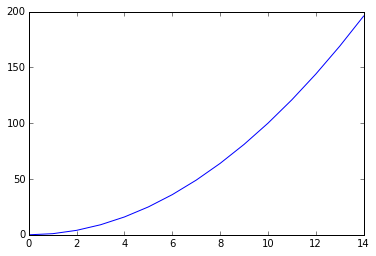

In [88]:
xs = []
ys = []
for d in analyzer.get_results():
    #print(d)
    xs.append(d['x'])
    ys.append(d['y'])

plt.plot(xs, ys)